# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [2]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
print("episode done ",env_info.local_done)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
episode done  [False]
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.30408478e+00 -1.00000000e+00
 -4.92529202e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.33014059e-01]


In [1]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from config import Config
from model2 import Actor, Critic
from memory import ReplayBuffer
from noise import OUNoise
from agent1 import DDPGAgent

import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]


config = Config()

config.seed = 2
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)

config.actor_hidden_units = (512, 256)
config.actor_learning_rate = 1e-4
config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (512, 256)
config.critic_learning_rate = 3e-4
config.weight_decay = 0
config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.batch_size = 512
config.buffer_size = int(1e6)
config.discount = 0.99
config.update_every = 4
config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)

config.noise_fn = lambda: OUNoise(config.action_size, config.seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
env_info.agents

[922]

In [3]:
from ddpg_agent import Agent
#agent = DDPGAgent(config)
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [4]:
def ddpg(n_episodes=5000, max_t=2000):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for _ in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
                
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

In [5]:
scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/home_01/f20150198/miniconda2/envs/python3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 2	Average Score: 0.30

KeyboardInterrupt: 

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
env = UnityEnvironment(file_name='Reacher.app')
from ddpg_agent import Agent
brain_name = env.brain_names[0]
num_agents =1
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

brain = env.brains[brain_name]
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
print("episode done ",env_info.local_done)
# examine the state space 
state = env_info.vector_observations
state_size = state.shape[1]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=3)
agent.actor_local
agent.critic_local.eval()
agent.actor_local.eval()
print(torch.load("checkpoint_critic_temp.pth", map_location=lambda storage, loc: storage).keys())
agent.critic_local.load_state_dict()
agent.actor_local.load_state_dict(torch.load("checkpoint_actor.pth", map_location=lambda storage, loc: storage))
while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Size of each action: 4
episode done  [False]
odict_keys(['normalizer.weight', 'normalizer.bias', 'normalizer.running_mean', 'normalizer.running_var', 'layers.0.weight', 'layers.0.bias', 'layers.1.weight', 'layers.1.bias', 'output.weight', 'output.bias'])


TypeError: load_state_dict() missing 1 required positional argument: 'state_dict'

In [1]:
from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment
import torch
import matplotlib.pyplot as plt
import numpy as np
env = UnityEnvironment(file_name='Reacher.app')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
print("episode done ",env_info.local_done)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=3)
#scores = np.zeros(1)                          # initialize the score (for each agent)
print("hello")
def ddpg(n_episodes=5000, max_t=2000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        #/print("mello")
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        #print("kello")
        state = env_info.vector_observations                 # get the current state (for each agent)
        score = np.zeros(1)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]           # send all actions to tne environment
            next_state = env_info.vector_observations         # get next state (for each agent)
            reward = env_info.rewards                        # get reward (for each agent)
            done = env_info.local_done                        # see if episode finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done[0]:
                break
        avg_score = np.mean(score)
        scores_deque.append(avg_score)
        scores.append(avg_score)
        print('\rEpisode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_deque)), end="")
        if np.mean(scores_deque) >= 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_temp.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_temp.pth')
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ddpg()
fig = plt.figure()
ax = fig.add_subplot(111)
print(scores)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig("graph.png")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Size of each action: 4
episode done  [False]
hello
Episode 1	Average Score: 0.00000000[0.0]


<Figure size 640x480 with 1 Axes>

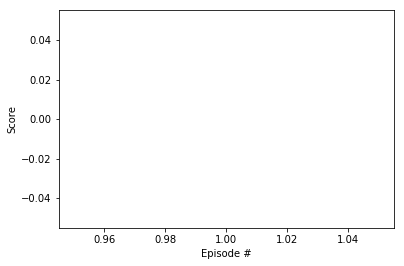

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
#scores = ddpg()
scores = [0]
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig("graph.png")

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```